# <center> **Data Mining Project Phase 2** **Boston Crime Analysis** </center>


# **Setup**

### **Importing the relevant libraries**

In [24]:
# %pip install mlxtend --upgrade

In [25]:
import math
import itertools
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import mlxtend

In [26]:
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from itertools import combinations
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [27]:
warnings.filterwarnings("ignore")

In [28]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

### **Loading the dataset**

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
data = pd.read_csv('/content/drive/MyDrive/Data Mining Group 2/Phase 2/cleanedDataset.csv',encoding = "ISO-8859-1")

In [31]:
data = data.drop("Unnamed: 0", axis = 1)
data

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,OFFENSE_CODE_GROUP,Location,Lat,Long,SHOOTING,STREET,DISTRICT
0,I192068249,2647,THREATS TO DO BODILY HARM,8/28/15 10:20,2015,8,Friday,10,Other,"(42.33011862, -71.08425106)",42.330119,-71.084251,0,WASHINGTON ST,B2
1,I192061894,1106,FRAUD - CREDIT CARD / ATM FRAUD,8/20/15 0:00,2015,8,Thursday,0,Confidence Games,"(42.30060543, -71.06126785)",42.300605,-71.061268,0,CHARLES ST,C11
2,I192038828,1107,FRAUD - IMPERSONATION,11/2/15 12:24,2015,11,Monday,12,Fraud,"(42.33428841, -71.07239518)",42.334288,-71.072395,0,ALBANY ST,A1
3,I192008877,1107,FRAUD - IMPERSONATION,7/31/15 10:00,2015,7,Friday,10,Fraud,"(42.23700950, -71.12956606)",42.237009,-71.129566,0,WINGATE RD,E18
4,I182090828,1102,FRAUD - FALSE PRETENSE / SCHEME,12/1/15 12:00,2015,12,Tuesday,12,Fraud,"(42.34243222, -71.07225766)",42.342432,-71.072258,0,UPTON ST,D4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550774,222004519,617,LARCENY THEFT FROM BUILDING,1/21/22 8:05,2022,1,Friday,8,Larceny,"(42.34990221314427, -71.06981556231642)",42.349902,-71.069816,0,ARLINGTON ST,A1
550775,222004517,520,BURGLARY - RESIDENTIAL,1/21/22 7:01,2022,1,Friday,7,Residential Burglary,"(42.340285737222054, -71.07145448799103)",42.340286,-71.071454,0,WASHINGTON ST,D4
550776,222004516,3126,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,1/21/22 7:25,2022,1,Friday,7,Other,"(42.33401828958511, -71.07638123930862)",42.334018,-71.076381,0,HARRISON AVE,D4
550777,122004001,3115,INVESTIGATE PERSON,1/19/22 9:30,2022,1,Wednesday,9,Investigate Person,"(42.326388322360614, -71.10181751253143)",42.326388,-71.101818,0,HEATH ST,E13


# **Clustering**

### **Function for Clustering** 

In [32]:
def doKmeans(dataFr, numClust):
    model = KMeans(numClust)
    model.fit(dataFr)
    labels = model.predict(dataFr)
    centroid = model.cluster_centers_
    return labels, centroid

### **Function for Elbow Method (WSS)** 

In [33]:
def elbowMethod(dataFr):
  sse = []

  for i in range(1,11):
    kmeans = KMeans(n_clusters = i).fit(dataFr)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(dataFr)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(dataFr)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (dataFr[i, 0] - curr_center[0]) ** 2 + (dataFr[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  
  plt.plot(range(1,11), sse, c = "black")
  plt.xlabel('Clusters')
  plt.ylabel('Within-Cluster-Sum of Squared')
  plt.title('Elbow Method')
  plt.show()

### **Function for Elbow Method (Inertia)**

In [34]:
def elbowMethodInertia(dataFr):
  inertia = []

  for i in range(1,11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',                 # Initialization method for kmeans
                    max_iter = 300,                     # Maximum number of iterations 
                    n_init = 10,                        # Choose how often algorithm will run with different centroid 
                    random_state = 0)                   # Choose random state for reproducibility
    model.fit(dataFr)                              
    inertia.append(model.inertia_)      
  
  plt.plot(range(1,11), inertia, c = "black")
  plt.xlabel('Clusters')
  plt.ylabel('Within-Cluster-Sum of Squared')
  plt.title('Elbow Method')
  plt.show()

### **Day & Offense Code Group**

In [35]:
dfCluster = data[['DAY_OF_WEEK','OFFENSE_CODE_GROUP']]
dfCluster

,DAY_OF_WEEK,OFFENSE_CODE_GROUP
0,Friday,Other
1,Thursday,Confidence Games
2,Monday,Fraud
3,Friday,Fraud
4,Tuesday,Fraud
...,...,...
550774,Friday,Larceny
550775,Friday,Residential Burglary
550776,Friday,Other
550777,Wednesday,Investigate Person


In [36]:
factorized_offense_code = pd.DataFrame(pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0])
factorized_day = pd.DataFrame(pd.factorize(dfCluster['DAY_OF_WEEK'])[0])

factorized = pd.concat([factorized_offense_code, factorized_day], axis = 1)
factorized.columns =['OFFENSE_CODE_GROUP_F', 'DAY_OF_WEEK_F']
factorized

,OFFENSE_CODE_GROUP_F,DAY_OF_WEEK_F
0,0,0
1,1,1
2,2,2
3,2,0
4,2,3
...,...,...
550774,5,0
550775,23,0
550776,0,0
550777,9,5


In [37]:
dfCluster = pd.concat([dfCluster, factorized], axis = 1)
dfCluster

,DAY_OF_WEEK,OFFENSE_CODE_GROUP,OFFENSE_CODE_GROUP_F,DAY_OF_WEEK_F
0,Friday,Other,0,0
1,Thursday,Confidence Games,1,1
2,Monday,Fraud,2,2
3,Friday,Fraud,2,0
4,Tuesday,Fraud,2,3
...,...,...,...,...
550774,Friday,Larceny,5,0
550775,Friday,Residential Burglary,23,0
550776,Friday,Other,0,0
550777,Wednesday,Investigate Person,9,5


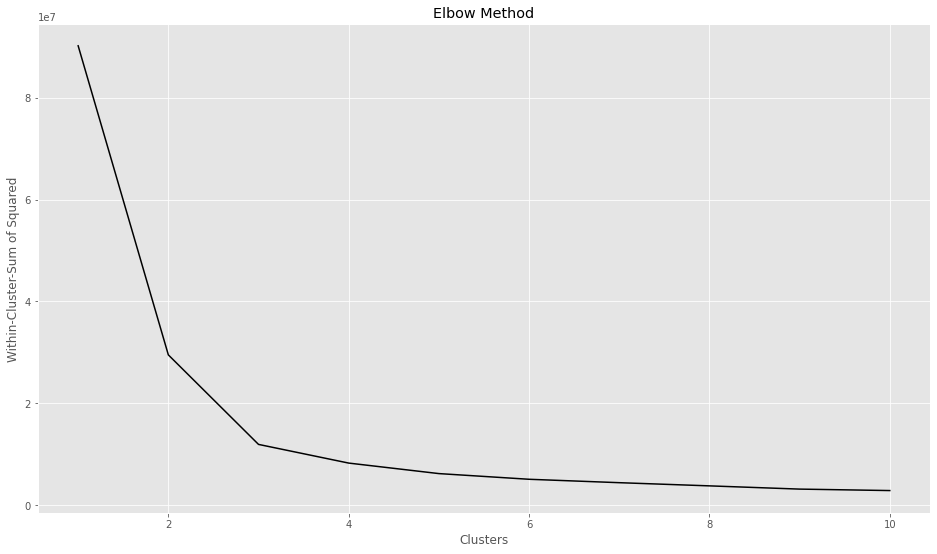

In [38]:
elbowMethod(dfCluster[["OFFENSE_CODE_GROUP_F", "DAY_OF_WEEK_F"]].to_numpy())


In [39]:
clust_labels, cent = doKmeans(dfCluster[["OFFENSE_CODE_GROUP_F", "DAY_OF_WEEK_F"]],3)

In [40]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

In [41]:
dfCluster = dfCluster.sort_values('DAY_OF_WEEK_F')

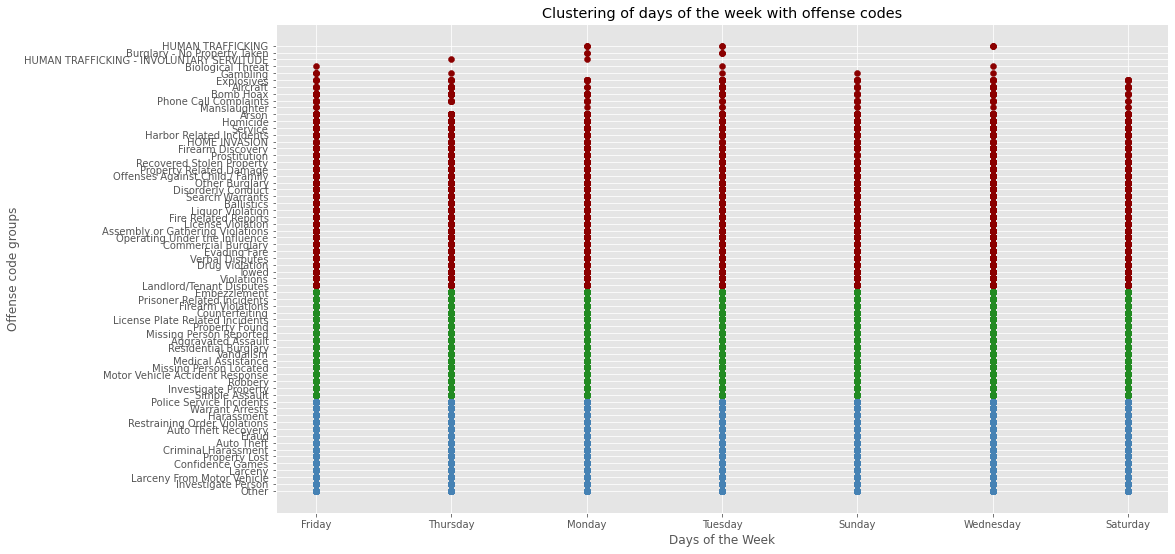

In [42]:
colors = ["steelblue", "forestgreen", "darkred"]
for i in range(3):
  temp = dfCluster[dfCluster["kmeans"] == i]
  plt.scatter(temp["DAY_OF_WEEK"],temp["OFFENSE_CODE_GROUP"], c = colors[i])

plt.xlabel("Days of the Week")
plt.ylabel("Offense code groups")
plt.title("Clustering of days of the week with offense codes")
plt.show()
  

### **Year & Offense Code/type**

In [53]:
dfCluster = data[['YEAR','OFFENSE_CODE_GROUP']]
dfCluster

,YEAR,OFFENSE_CODE_GROUP
0,2015,Other
1,2015,Confidence Games
2,2015,Fraud
3,2015,Fraud
4,2015,Fraud
...,...,...
550774,2022,Larceny
550775,2022,Residential Burglary
550776,2022,Other
550777,2022,Investigate Person


In [54]:
factorized_offense_code = pd.DataFrame(pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0])

factorized = pd.concat([factorized_offense_code], axis = 1)
factorized.columns =['OFFENSE_CODE_GROUP_F']
factorized

,OFFENSE_CODE_GROUP_F
0,0
1,1
2,2
3,2
4,2
...,...
550774,5
550775,23
550776,0
550777,9


In [55]:
dfCluster = pd.concat([dfCluster, factorized], axis = 1)
dfCluster

,YEAR,OFFENSE_CODE_GROUP,OFFENSE_CODE_GROUP_F
0,2015,Other,0
1,2015,Confidence Games,1
2,2015,Fraud,2
3,2015,Fraud,2
4,2015,Fraud,2
...,...,...,...
550774,2022,Larceny,5
550775,2022,Residential Burglary,23
550776,2022,Other,0
550777,2022,Investigate Person,9


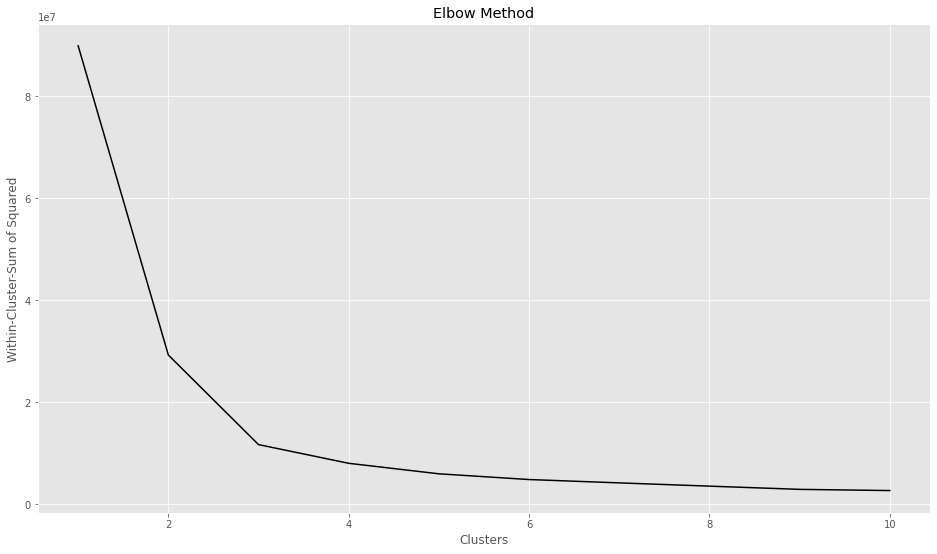

In [56]:
elbowMethod(dfCluster[["OFFENSE_CODE_GROUP_F", "YEAR"]].to_numpy())

In [57]:
clust_labels, cent = doKmeans(dfCluster[["OFFENSE_CODE_GROUP_F", "YEAR"]],3)

In [58]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

In [59]:
dfCluster = dfCluster.sort_values('YEAR')

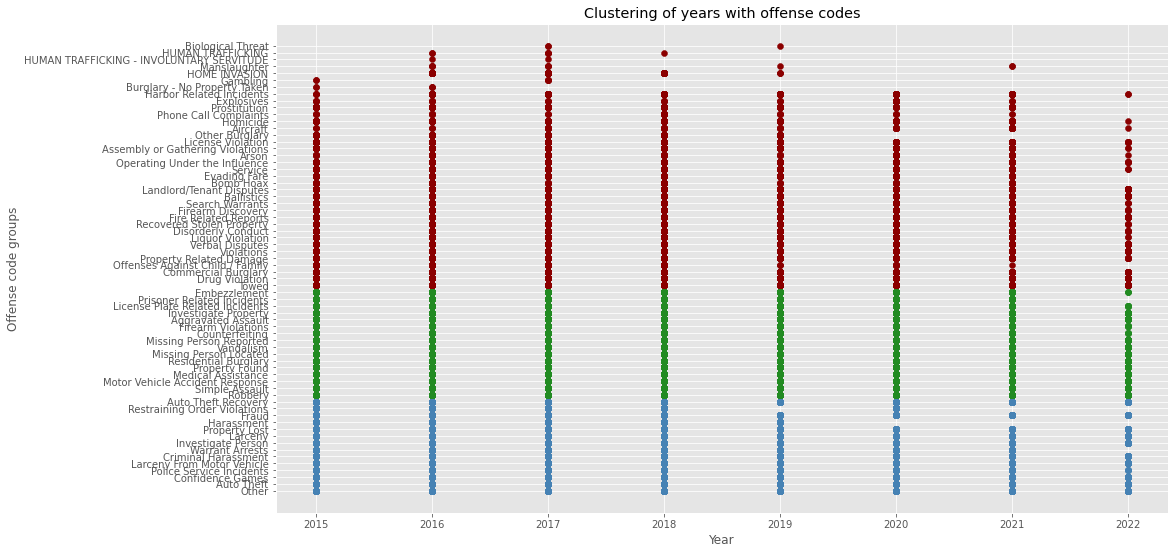

In [60]:
colors = ["steelblue", "forestgreen", "darkred"]
for i in range(3):
  temp = dfCluster[dfCluster["kmeans"] == i]
  plt.scatter(temp["YEAR"],temp["OFFENSE_CODE_GROUP"], c = colors[i])

plt.xlabel("Year")
plt.ylabel("Offense code groups")
plt.title("Clustering of years with offense codes")
plt.show()

### **Location & Motor Vehicle Accident**


In [61]:
dfCluster = data[['OFFENSE_CODE_GROUP','Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

In [62]:
dfCluster = dfCluster.loc[(dfCluster['OFFENSE_CODE_GROUP'] == 'Motor Vehicle Accident Response')]

In [63]:
dfCluster['OFFENSE_CODE_GROUP'] = pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0]

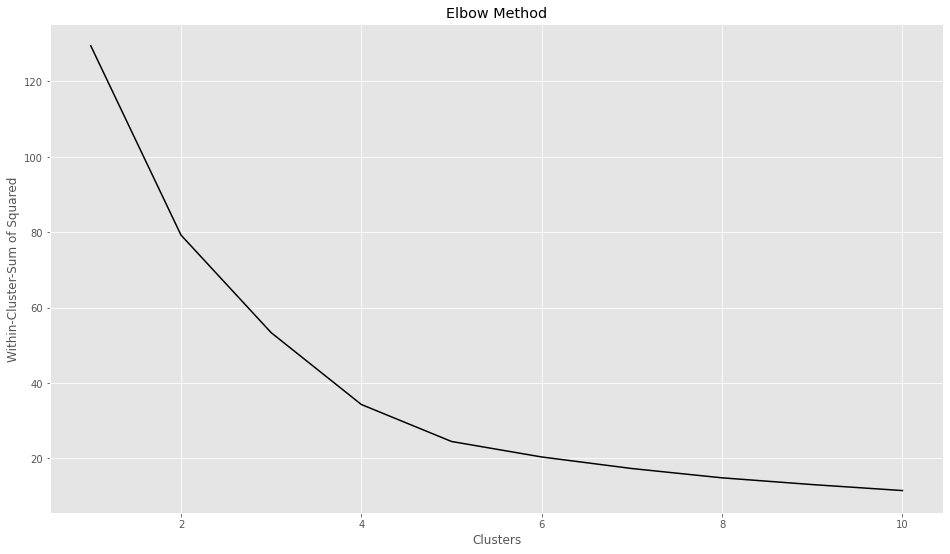

In [23]:
elbowMethodInertia(dfCluster)

In [64]:
clust_labels, cent = doKmeans(dfCluster,5)

In [65]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

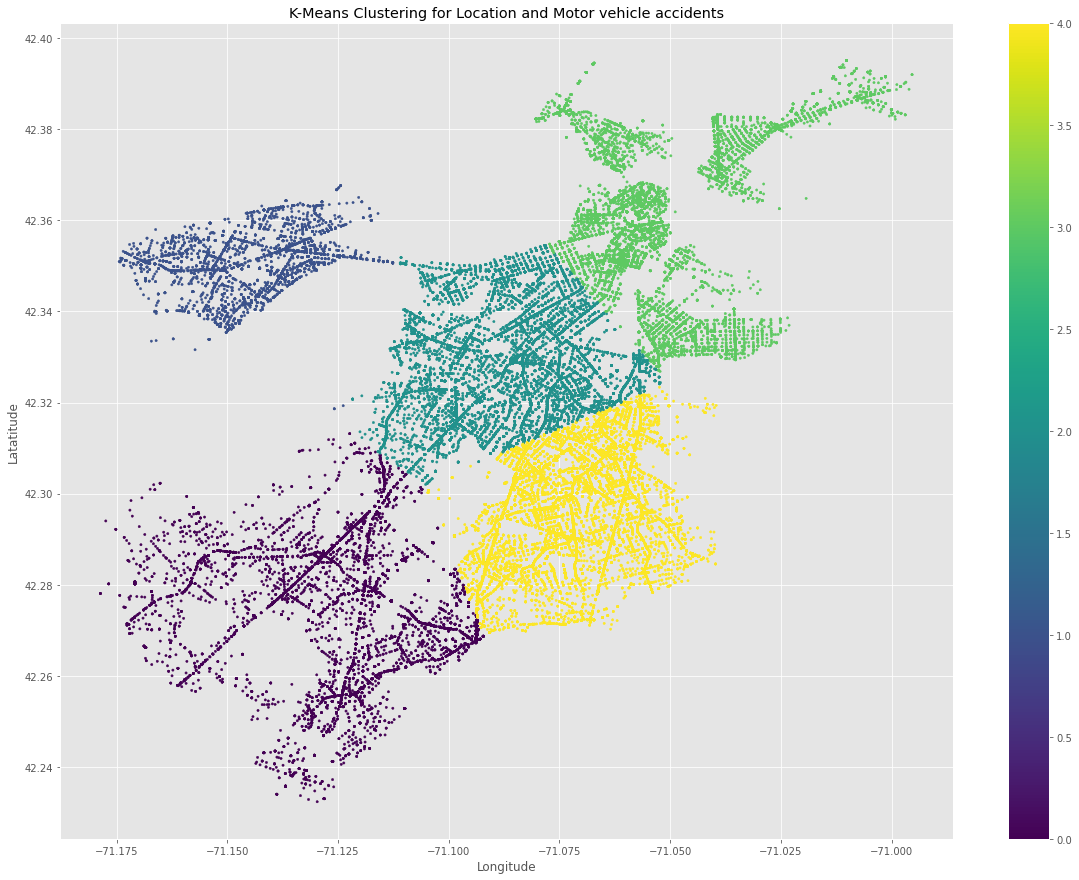

In [66]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering for Location and Motor vehicle accidents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

### **Location & Larceny**




In [67]:
dfCluster = data[['OFFENSE_CODE_GROUP','Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

In [68]:
dfCluster = dfCluster.loc[(dfCluster['OFFENSE_CODE_GROUP'] == 'Larceny')]

In [69]:
dfCluster['OFFENSE_CODE_GROUP'] = pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0]

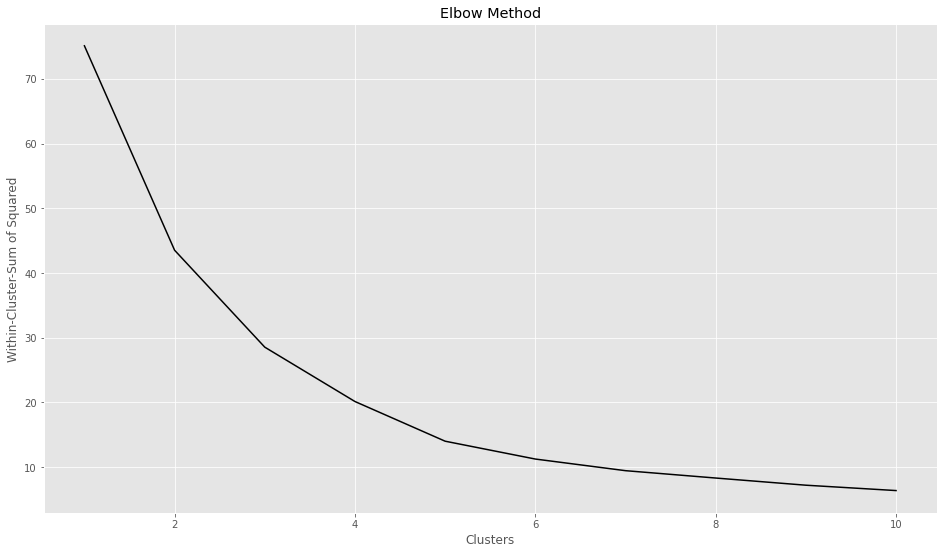

In [70]:
elbowMethodInertia(dfCluster)

In [71]:
clust_labels, cent = doKmeans(dfCluster,5)

In [72]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

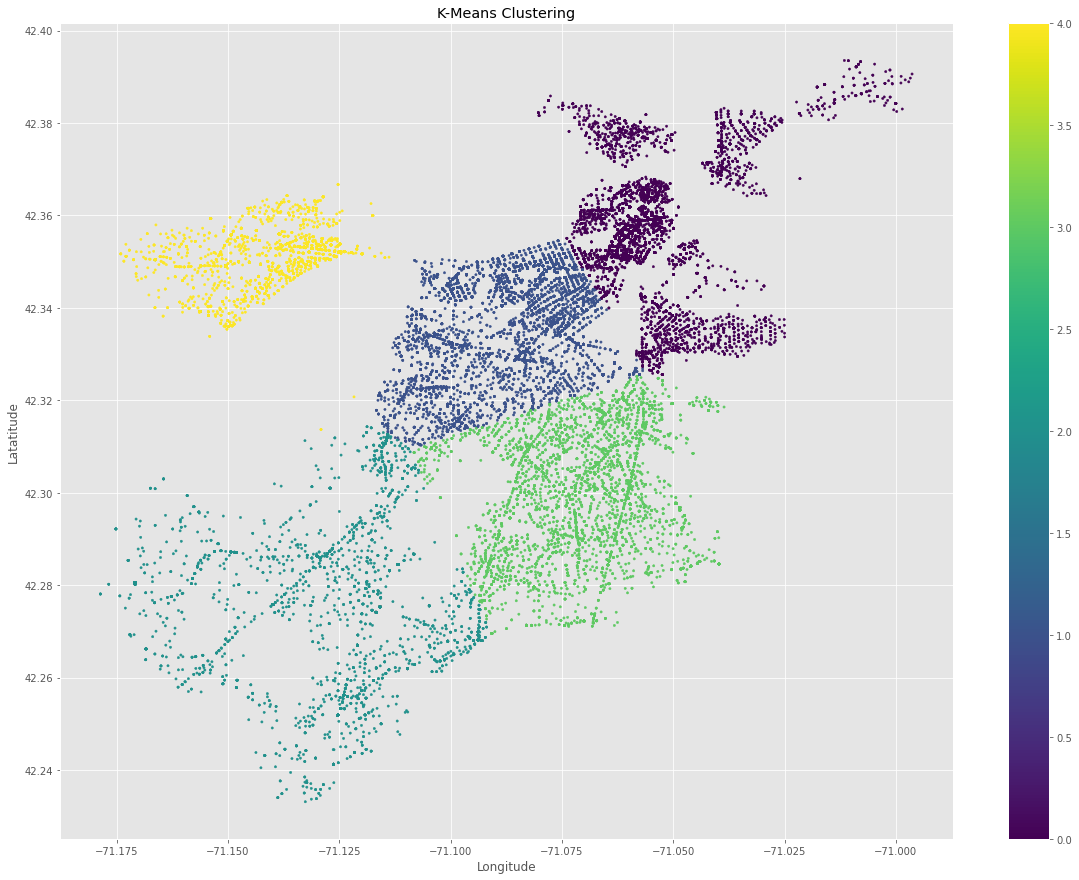

In [73]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

### **Location and Medical Assistance**


In [74]:
dfCluster = data[['OFFENSE_CODE_GROUP','Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

In [75]:
dfCluster = dfCluster.loc[(dfCluster['OFFENSE_CODE_GROUP'] == 'Medical Assistance')]

In [76]:
dfCluster['OFFENSE_CODE_GROUP'] = pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0]

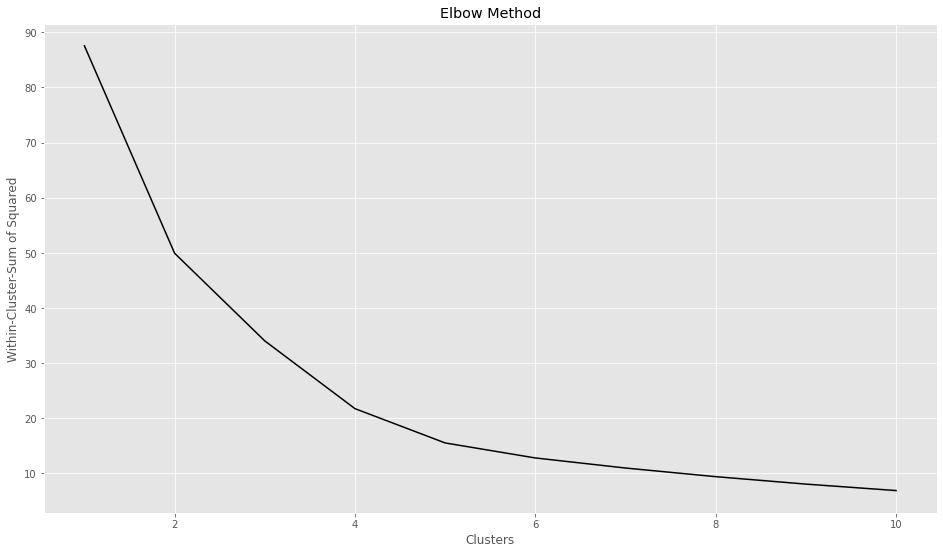

In [77]:
elbowMethodInertia(dfCluster)

In [78]:
clust_labels, cent = doKmeans(dfCluster,5)

In [79]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

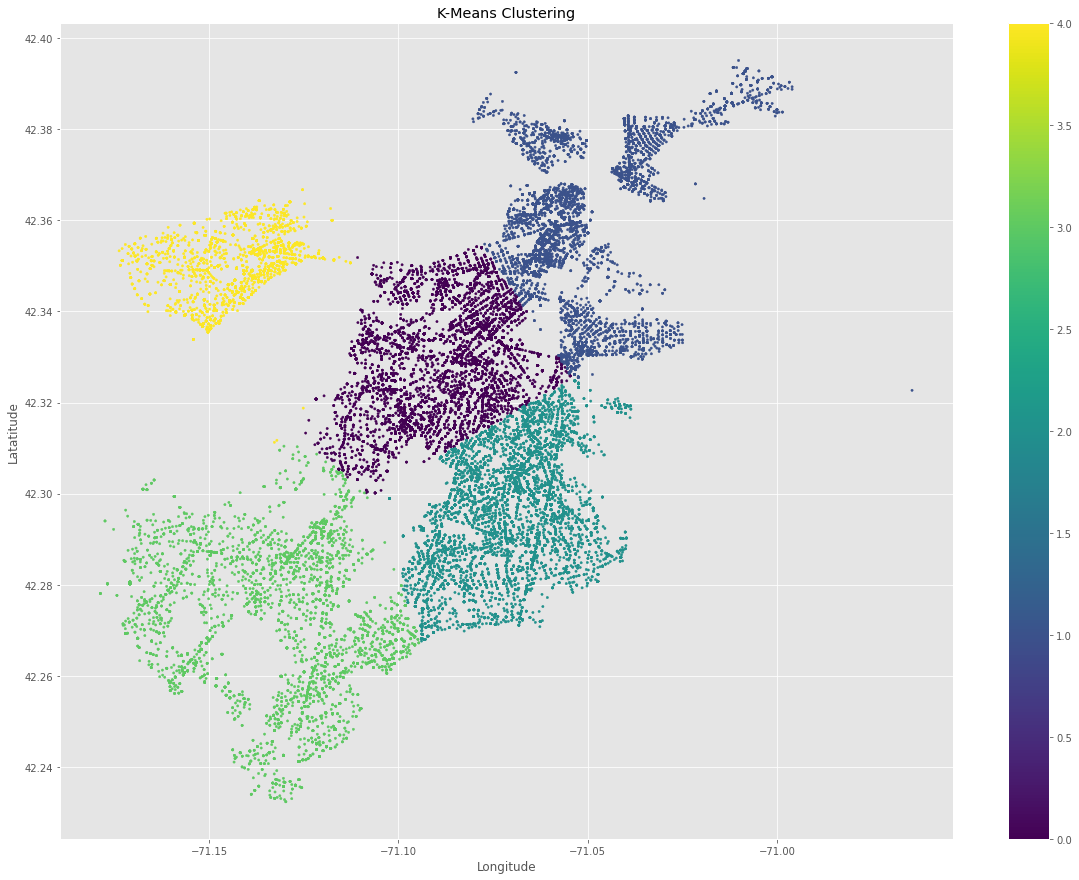

In [80]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

### **Location and Shooting**

In [81]:
dfCluster = data[['SHOOTING','Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

In [82]:
dfCluster['SHOOTING'] = pd.factorize(dfCluster['SHOOTING'])[0]

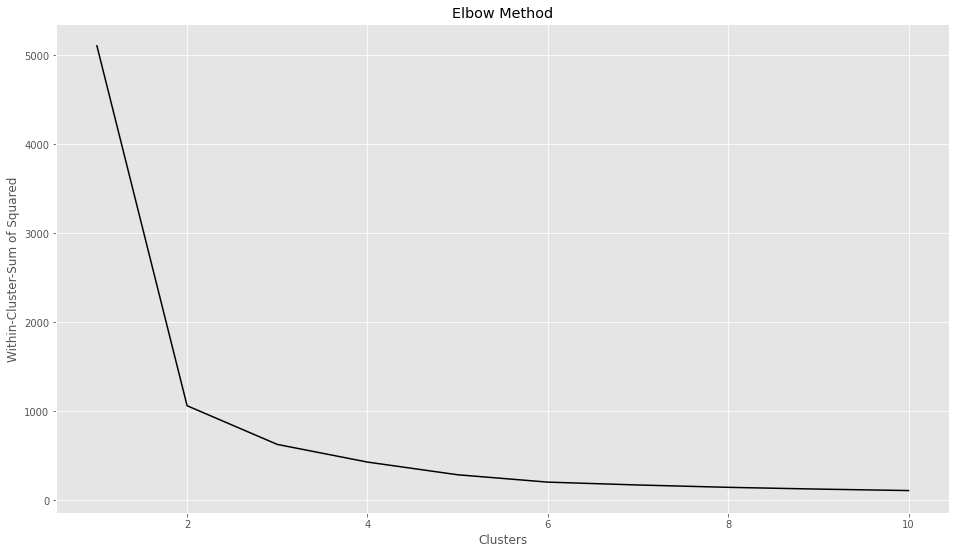

In [83]:
elbowMethodInertia(dfCluster)

In [84]:
clust_labels, cent = doKmeans(dfCluster,2)

In [85]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

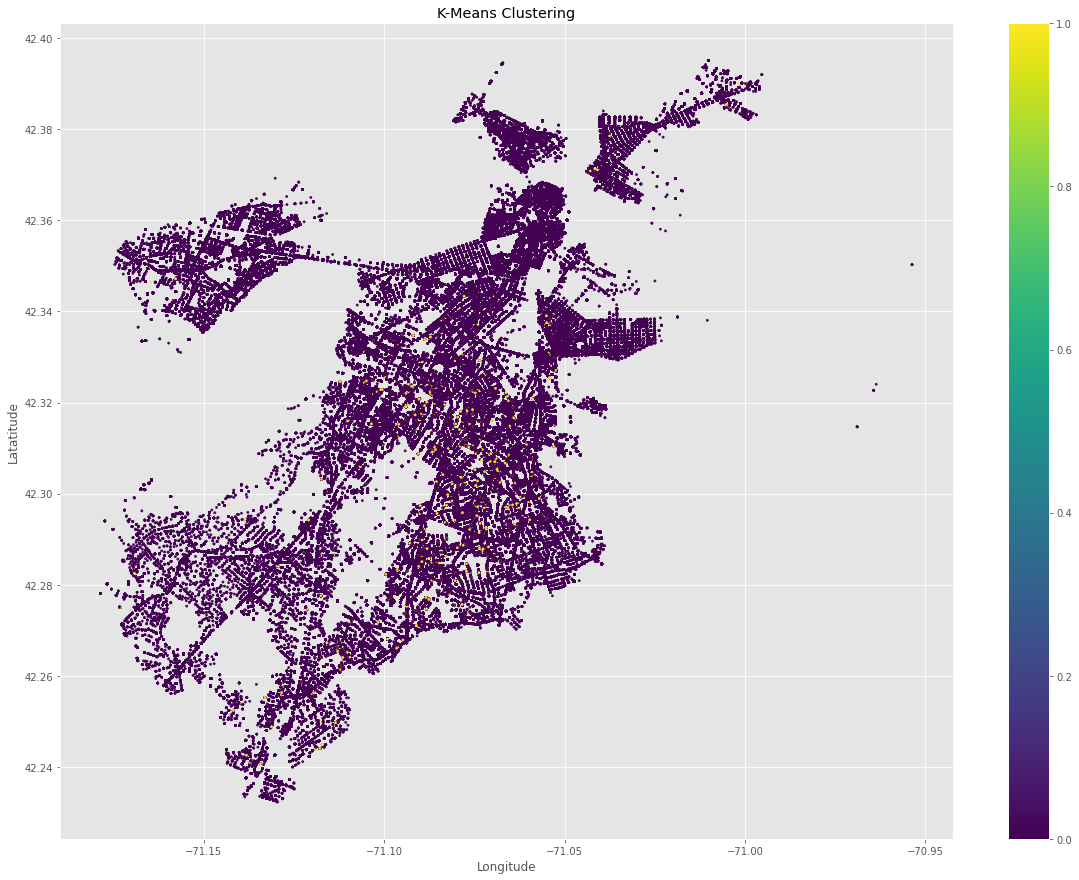

In [86]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

### **Cluster Analysis on Location**

In [87]:
dfCluster = data[['Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

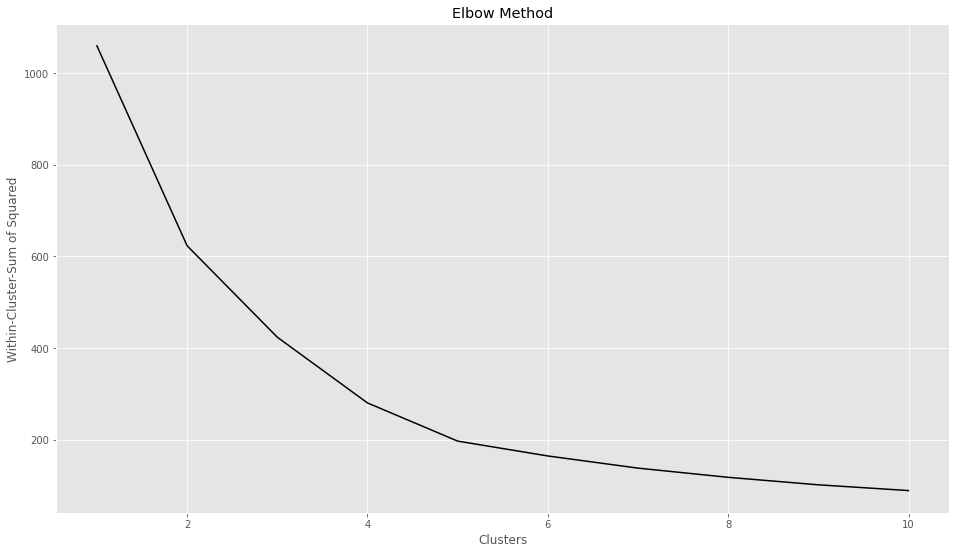

In [88]:
elbowMethod(dfCluster.to_numpy())

In [89]:
clust_labels, cent = doKmeans(dfCluster,5)

In [90]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

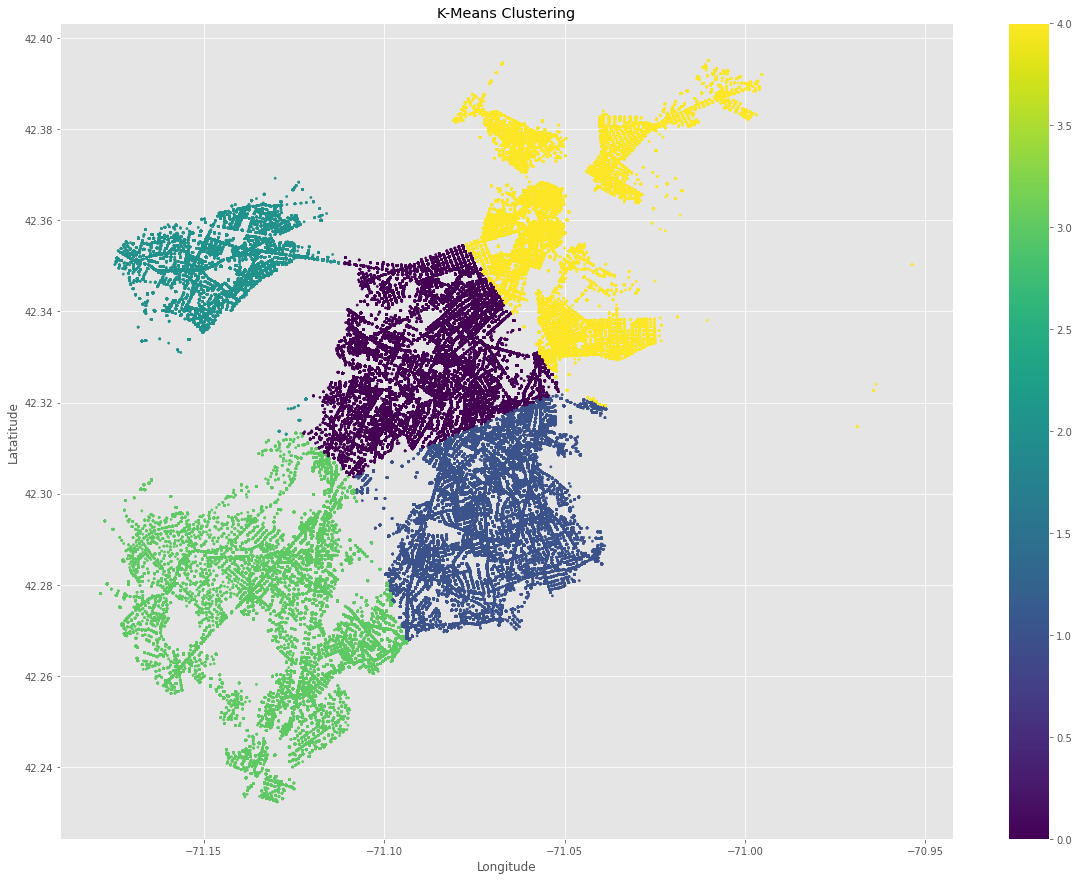

In [91]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

### **Location and Offense Code Group**

In [92]:
dfCluster = data[['OFFENSE_CODE_GROUP','Long','Lat']]
dfCluster = dfCluster.loc[(dfCluster['Lat'] > 40) & (dfCluster['Long'] < -60)]

In [93]:
dfCluster['OFFENSE_CODE_GROUP'] = pd.factorize(dfCluster['OFFENSE_CODE_GROUP'])[0]

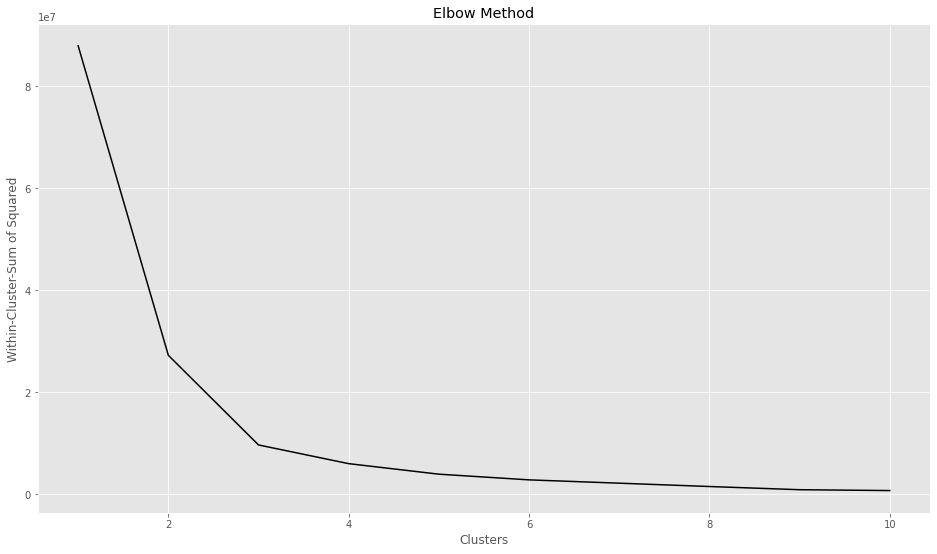

In [94]:
# elbowMethod(dfCluster.to_numpy())
elbowMethodInertia(dfCluster)

In [95]:
clust_labels, cent = doKmeans(dfCluster,3)

In [96]:
kmeans = pd.DataFrame(clust_labels)
dfCluster.insert((dfCluster.shape[1]),'kmeans',kmeans)

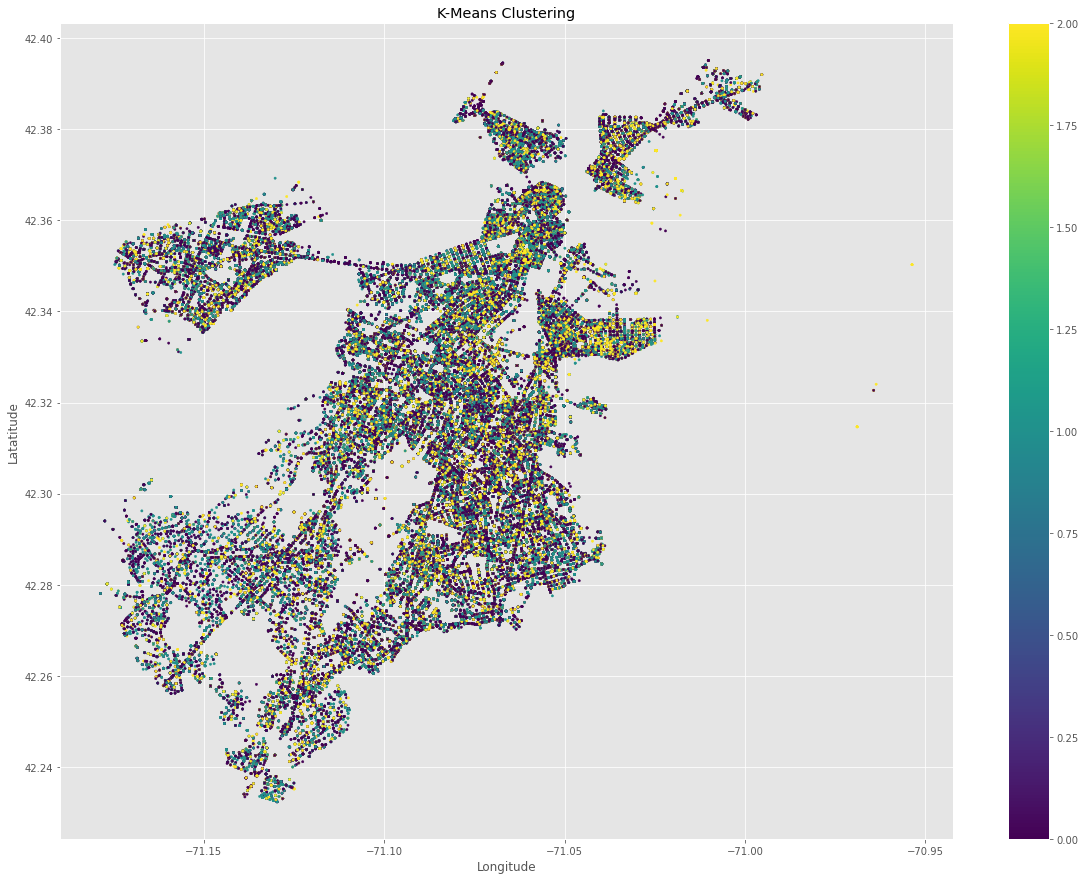

In [97]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfCluster['Long'],dfCluster['Lat'],c=kmeans[0],s=5)

ax.set_title('K-Means Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latatitude')
plt.colorbar(scatter)
plt.show()

# **Frequent Pattern Mining**

In [98]:
# Feature Selection 
selected_features = ["OFFENSE_CODE_GROUP", "YEAR", "MONTH", "DAY_OF_WEEK", "HOUR", "STREET", "DISTRICT"]
newdf = data.loc[:, selected_features]

# Feature Modification 
newdf['MONTH'] = newdf['MONTH'].map({1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 
                        8:"August", 9: "Setember", 10: "October", 11: "November", 12:"December"})

newdf["HOUR"] = newdf["HOUR"].map({0: "H0", 1: "H1", 2: "H2", 3:"H3", 4:"H4", 5:"H5", 6:"H6", 7:"H7", 8:"H8", 9:"H9", 10:"H10", 
                       11:"H11", 12:"H12", 13:"H13", 14:"H14", 15:"H15", 16:"H16", 17:"H17", 18:"H18", 19:"H19",
                       20:"H20", 21:"H21", 22:"H22"})

### **2015**


In [99]:
# Filter Data by Year (2015)
filter_by_year = newdf[newdf['YEAR'] == 2015] 
overall_crimes = filter_by_year.drop(columns=['YEAR'])
region_crimes = filter_by_year.drop(columns=['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR'])
time_crimes = filter_by_year.drop(columns=['YEAR', 'STREET', 'DISTRICT'])
# Convert filtered data to csv 
region_crimes.to_csv('regionDataset.csv', index = False)
time_crimes.to_csv('timeDataset.csv', index = False)
overall_crimes.to_csv('newDataset.csv', index  = False)

In [100]:
#TREND BY REGION 
#Read the csv file 
with open("regionDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# Apriori 
result = apriori(sparse_df, min_support=0.01, use_colnames=True, verbose=1)
result['length'] = result['itemsets'].map(len)
result 
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

Processing 126 combinations | Sampling itemset size 3


,support,itemsets,length
47,0.011832,"(Other, B2)",2
48,0.010331,"(A1, WASHINGTON ST)",2
49,0.026550,"(Larceny, D4)",2
50,0.017258,"(Larceny, A1)",2
51,0.011524,"(Larceny, B2)",2
52,0.015238,"(BLUE HILL AVE, B3)",2
53,0.014891,"(DORCHESTER AVE, C11)",2
54,0.016815,"(BOYLSTON ST, D4)",2
55,0.010543,"(B3, Motor Vehicle Accident Response)",2
56,0.014833,"(Motor Vehicle Accident Response, C11)",2


In [101]:
#TREND BY TIME
#Read the csv file 
with open("timeDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2  
freq  = result2[result2['length'] >=2]
freq 
# for i in freq['itemsets']:
#   print(i)

,support,itemsets,length
63,0.021567,"(August, Friday)",2
64,0.027397,"(July, Friday)",2
65,0.022221,"(Setember, Friday)",2
66,0.027955,"(October, Friday)",2
67,0.010524,"(Other, August)",2
...,...,...,...
151,0.016065,"(October, Motor Vehicle Accident Response)",2
152,0.010620,"(Wednesday, Drug Violation)",2
153,0.011794,"(Tuesday, Drug Violation)",2
154,0.011178,"(October, Drug Violation)",2


In [102]:
#OVERALL TREND
#Read the csv file 
with open("newDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

,support,itemsets,length
85,0.025242,"(B2, August)",2
86,0.024896,"(B2, Friday)",2
87,0.021567,"(August, Friday)",2
88,0.027397,"(July, Friday)",2
89,0.022221,"(Setember, Friday)",2
...,...,...,...
273,0.010966,"(D4, HARRISON AVE)",2
274,0.010620,"(Wednesday, Drug Violation)",2
275,0.011794,"(Tuesday, Drug Violation)",2
276,0.011178,"(October, Drug Violation)",2


### **2016** 

In [103]:
# Filter Data by Year (2016)
filter_by_year = newdf[newdf['YEAR'] == 2016] 
overall_crimes = filter_by_year.drop(columns=['YEAR'])
region_crimes = filter_by_year.drop(columns=['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR'])
time_crimes = filter_by_year.drop(columns=['YEAR', 'STREET', 'DISTRICT'])
# Convert filtered data to csv 
region_crimes.to_csv('regionDataset.csv', index = False)
time_crimes.to_csv('timeDataset.csv', index = False)
overall_crimes.to_csv('newDataset.csv', index  = False)

In [104]:
#TREND BY REGION 
#Read the csv file 
with open("regionDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

,support,itemsets,length
48,0.014621,"(A1, Larceny)",2
49,0.023257,"(D4, Larceny)",2
50,0.010599,"(Other, B2)",2
51,0.014031,"(DORCHESTER AVE, C11)",2
52,0.015480,"(BLUE HILL AVE, B3)",2
53,0.010363,"(B2, Medical Assistance)",2
54,0.010491,"(C11, Medical Assistance)",2
55,0.016660,"(BOYLSTON ST, D4)",2
56,0.010202,"(B3, Verbal Disputes)",2
57,0.016198,"(Motor Vehicle Accident Response, C11)",2


In [105]:
#TREND BY TIME
#Read the csv file 
with open("timeDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2  
freq  = result2[result2['length'] >=2]
freq 
# for i in freq['itemsets']:
#     print(i)

,support,itemsets,length
68,0.014761,"(Setember, Thursday)",2
69,0.010996,"(Setember, Tuesday)",2
70,0.010803,"(Saturday, Setember)",2
71,0.011232,"(Setember, Monday)",2
72,0.011264,"(Wednesday, Setember)",2
...,...,...,...
164,0.015898,"(Saturday, Motor Vehicle Accident Response)",2
165,0.014257,"(Thursday, Motor Vehicle Accident Response)",2
166,0.013967,"(Motor Vehicle Accident Response, Sunday)",2
167,0.014182,"(Wednesday, Motor Vehicle Accident Response)",2


In [106]:
#OVERALL TREND
#Read the csv file 
with open("newDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

,support,itemsets,length
91,0.024147,"(Thursday, B2)",2
92,0.020758,"(Thursday, C11)",2
93,0.020296,"(Saturday, C11)",2
94,0.020672,"(Tuesday, C11)",2
95,0.020253,"(Monday, C11)",2
...,...,...,...
275,0.014257,"(Thursday, Motor Vehicle Accident Response)",2
276,0.013967,"(Motor Vehicle Accident Response, Sunday)",2
277,0.011296,"(B3, Motor Vehicle Accident Response)",2
278,0.014182,"(Wednesday, Motor Vehicle Accident Response)",2


### **2017** 

In [107]:
# Filter Data by Year (2017)
filter_by_year = newdf[newdf['YEAR'] == 2017] 
overall_crimes = filter_by_year.drop(columns=['YEAR'])
region_crimes = filter_by_year.drop(columns=['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR'])
time_crimes = filter_by_year.drop(columns=['YEAR', 'STREET', 'DISTRICT'])
# Convert filtered data to csv 
region_crimes.to_csv('regionDataset.csv', index = False)
time_crimes.to_csv('timeDataset.csv', index = False)
overall_crimes.to_csv('newDataset.csv', index  = False)

#TREND BY REGION 

#Read the csv file 
with open("regionDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
print(len(freq))
freq 

17


,support,itemsets,length
47,0.014052,"(Larceny, A1)",2
48,0.020609,"(D4, Larceny)",2
49,0.010238,"(D4, HARRISON AVE)",2
50,0.016295,"(BLUE HILL AVE, B3)",2
51,0.010422,"(Investigate Person, B2)",2
52,0.010146,"(Other, B2)",2
53,0.014286,"(DORCHESTER AVE, C11)",2
54,0.016295,"(BOYLSTON ST, D4)",2
55,0.016346,"(Motor Vehicle Accident Response, C11)",2
56,0.011390,"(D4, Motor Vehicle Accident Response)",2


In [108]:
#TREND BY TIME
#Read the csv file 
with open("timeDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2  
freq  = result2[result2['length'] >=2]
freq 
# for i in freq['itemsets']:
#     print(i)

,support,itemsets,length
67,0.014980,"(Wednesday, August)",2
68,0.014878,"(Tuesday, August)",2
69,0.010656,"(August, Sunday)",2
70,0.011268,"(Saturday, August)",2
71,0.015500,"(Thursday, August)",2
...,...,...,...
167,0.010075,"(Saturday, Medical Assistance)",2
168,0.011227,"(Friday, Medical Assistance)",2
169,0.012594,"(Thursday, Medical Assistance)",2
170,0.010911,"(Monday, Medical Assistance)",2


In [109]:
#OVERALL TREND
#Read the csv file 
with open("newDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

,support,itemsets,length
90,0.024361,"(Wednesday, B2)",2
91,0.019874,"(Wednesday, C11)",2
92,0.019344,"(Thursday, C11)",2
93,0.019864,"(Friday, C11)",2
94,0.020507,"(Tuesday, C11)",2
...,...,...,...
288,0.012594,"(Thursday, Medical Assistance)",2
289,0.010911,"(Monday, Medical Assistance)",2
290,0.011237,"(Tuesday, Medical Assistance)",2
291,0.010258,"(B3, Verbal Disputes)",2


### **2018**

In [110]:
# Filter Data by Year (2018)
filter_by_year = newdf[newdf['YEAR'] == 2018] 
overall_crimes = filter_by_year.drop(columns=['YEAR'])
region_crimes = filter_by_year.drop(columns=['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR'])
time_crimes = filter_by_year.drop(columns=['YEAR', 'STREET', 'DISTRICT'])
# Convert filtered data to csv 
region_crimes.to_csv('regionDataset.csv', index = False)
time_crimes.to_csv('timeDataset.csv', index = False)
overall_crimes.to_csv('newDataset.csv', index  = False)

#TREND BY REGION 

#Read the csv file 
with open("regionDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
print(len(freq))
freq 

15


,support,itemsets,length
47,0.022834,"(Larceny, D4)",2
48,0.015899,"(A1, Larceny)",2
49,0.010372,"(HYDE PARK AVE, E18)",2
50,0.016313,"(BLUE HILL AVE, B3)",2
51,0.010796,"(BLUE HILL AVE, B2)",2
52,0.013932,"(DORCHESTER AVE, C11)",2
53,0.010330,"(Other, B2)",2
54,0.011417,"(C11, Medical Assistance)",2
55,0.012307,"(B2, Medical Assistance)",2
56,0.017183,"(BOYLSTON ST, D4)",2


In [111]:
#TREND BY TIME
#Read the csv file 
with open("timeDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2  
freq  = result2[result2['length'] >=2]
freq 
# for i in freq['itemsets']:
#     print(i)

,support,itemsets,length
67,0.012794,"(April, Monday)",2
68,0.010920,"(April, Tuesday)",2
69,0.011541,"(April, Friday)",2
70,0.011407,"(Wednesday, April)",2
71,0.011428,"(April, Saturday)",2
...,...,...,...
161,0.015837,"(Motor Vehicle Accident Response, Sunday)",2
162,0.016499,"(Tuesday, Motor Vehicle Accident Response)",2
163,0.016230,"(Wednesday, Motor Vehicle Accident Response)",2
164,0.016013,"(Saturday, Motor Vehicle Accident Response)",2


In [112]:
#OVERALL TREND
#Read the csv file 
with open("newDataset.csv","r") as file:
    output = csv.reader(file)
    dataset = list(output)

del dataset[0] #Remove the first list with column names 

# Transform to Transactions 
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# FP Growth 
result2 = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
result2['length'] = result2['itemsets'].map(len)
result2 
freq  = result2[result2['length'] >=2]
freq 

,support,itemsets,length
90,0.022803,"(B2, Monday)",2
91,0.017628,"(Monday, B3)",2
92,0.014895,"(B3, Sunday)",2
93,0.017090,"(Thursday, B3)",2
94,0.016593,"(Saturday, B3)",2
...,...,...,...
282,0.016013,"(Saturday, Motor Vehicle Accident Response)",2
283,0.011490,"(D4, Motor Vehicle Accident Response)",2
284,0.012069,"(B3, Motor Vehicle Accident Response)",2
285,0.015827,"(Thursday, Motor Vehicle Accident Response)",2
